#                                             Final Project

In [52]:
#imporn nessasary packages
import pandas as pd
import numpy as np
import re
#from autocorrect import spell
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import csv
from textblob import TextBlob
import pandas
import sklearn
from nltk.stem import LancasterStemmer
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from itertools import combinations 

FedCentral is platform that was created for non-profit Jewish organizations. It allows users to search for materials such as documents, photos and videos. Those materials are usually used for web pages, printouts, training sessions or for various fundraising or educational campaigns.

<img src="fed1.png" width="800"/>

Each document has title, short decription, long description and tags.

<img src="fed2.png"/>

The first goal of the project is to improve search algorithm. The current search algorithm sometimes returns irrelevant results.

The requirmernts of the search algorithm are:

1. Algorithm should find materials that contain exact or partial keyword match.
2. Materials with exact keyword match should appear in main results while materials with partial keryword match should appear in related results section.
3. Search results should be sorted based on frequency of occurrence of keywords in material content.
4. Results that have keyword match in title should appear above materials that have keyword match in description or tags.

First, I created the function that loads the dataset.

In [53]:
def load_dataset(dataset):
    df = pd.read_csv(dataset)
    return df

#import materials dataset
materials = load_dataset('assets.csv')
materials.head(3)

,ID,Date Uploaded,Date Approved,Display Name,Type of File,Author (name),Author (email),Description,Short Description,File Use,...,Optimized for Web Use,Downloadable,Packages,Marketing Materials,Design File,Graphics,Best Practices,Research & reports,Training Materials,Public Tag Names
0,368719,8/26/15 19:08,9/4/15 13:13,GA2015_1800x650_fedweb.jpg,jpg,Davi Ellis,davi@luminantdigital.com,NaN,GA2015_1800x650_fedweb.jpg,web,...,N,N,NaN,N,N,N,N,N,N,NaN
1,369549,9/4/15 14:38,9/4/15 14:38,Campers Play Behind Israeli Flags,jpg,Hindy Gershman,hindy.gershman@jewishfederations.org,<p>A group of young boy campers play near a vo...,Kids play behind Israeli flags.,full,...,N,Y,NaN,N,N,N,N,N,N,young | children | outdoors | israel | magen d...
2,369550,9/4/15 14:38,9/4/15 14:38,Group of Adults Sitting Outdoors,JPG,Hindy Gershman,hindy.gershman@jewishfederations.org,<p>A group of men and women adults sit togethe...,Group of adults.,full,...,N,Y,NaN,N,N,N,N,N,N,community | outdoors | outside | adults | man ...


After that I performed the following modifications with materials data:
1. Replaced NAs with blanks, so that NAs don't block NLP functions.  
2. Removed meangless characters such as HTML tags.
3. Fixed special characters issue (some of the special characters didn't appear correctly in csv file).
4. Removed punctuation.
5. Implemented tokenization(breaking a stream of text up into words).
6. Removed stop words.
7. Converted words to their base forms - lemmas.

In [54]:
#function that replaces NAs with blanks
def replace_na(df,columns):
    df[columns] = df[columns].fillna('')

columns_list = ['Display Name','Short Description','Description','Public Tag Names']
replace_na(materials,columns_list)
materials[columns_list].head(3)  

,Display Name,Short Description,Description,Public Tag Names
0,GA2015_1800x650_fedweb.jpg,GA2015_1800x650_fedweb.jpg,,
1,Campers Play Behind Israeli Flags,Kids play behind Israeli flags.,<p>A group of young boy campers play near a vo...,young | children | outdoors | israel | magen d...
2,Group of Adults Sitting Outdoors,Group of adults.,<p>A group of men and women adults sit togethe...,community | outdoors | outside | adults | man ...


In [55]:
#function that removes html tags
def remove_html(df,columns):
    patterns = ['<p>','</p>','<em>','</em>','<a>','</a>','|']
    for column in columns:
        for pattern in patterns:
            df[column] = df[column].str.replace(pattern,'')

remove_html(materials,columns_list)
materials[columns_list].head(3)  

,Display Name,Short Description,Description,Public Tag Names
0,GA2015_1800x650_fedweb.jpg,GA2015_1800x650_fedweb.jpg,,
1,Campers Play Behind Israeli Flags,Kids play behind Israeli flags.,A group of young boy campers play near a volle...,young children outdoors israel magen david...
2,Group of Adults Sitting Outdoors,Group of adults.,A group of men and women adults sit together o...,community outdoors outside adults man wom...


In [56]:
#function that adjusts some of the special characters
def adjust_sp_ch(df,columns):
    patterns = ['&quot;']
    for column in columns:
        for pattern in patterns:
            df[column] = df[column].str.replace(pattern,'"') 

adjust_sp_ch(materials,columns_list)
materials[columns_list].head(3)  

,Display Name,Short Description,Description,Public Tag Names
0,GA2015_1800x650_fedweb.jpg,GA2015_1800x650_fedweb.jpg,,
1,Campers Play Behind Israeli Flags,Kids play behind Israeli flags.,A group of young boy campers play near a volle...,young children outdoors israel magen david...
2,Group of Adults Sitting Outdoors,Group of adults.,A group of men and women adults sit together o...,community outdoors outside adults man wom...


In [57]:
#function that removes punctuation
def remove_commas(df, columns):
    for column in columns:
        df[column] = df[column].str.replace(r'[^\w\s]','')

        
remove_commas(materials,columns_list)
materials[columns_list].head(3)     

,Display Name,Short Description,Description,Public Tag Names
0,GA2015_1800x650_fedwebjpg,GA2015_1800x650_fedwebjpg,,
1,Campers Play Behind Israeli Flags,Kids play behind Israeli flags,A group of young boy campers play near a volle...,young children outdoors israel magen david...
2,Group of Adults Sitting Outdoors,Group of adults,A group of men and women adults sit together o...,community outdoors outside adults man wom...


In [58]:
# function that implements tokenization and removes stop words
def apply_tokenization(df, columns):
    stop_words = set(stopwords.words('english'))
    for column in columns_list:
        df[column] = df[column].apply(word_tokenize)
        #remove stop words    
        for i in range(0,len(df)):
            df[column][i] =[w for w in df[column][i] if w not in stop_words]    

apply_tokenization(materials,columns_list)
materials[columns_list].head(3) 

,Display Name,Short Description,Description,Public Tag Names
0,[GA2015_1800x650_fedwebjpg],[GA2015_1800x650_fedwebjpg],[],[]
1,"[Campers, Play, Behind, Israeli, Flags]","[Kids, play, behind, Israeli, flags]","[A, group, young, boy, campers, play, near, vo...","[young, children, outdoors, israel, magen, dav..."
2,"[Group, Adults, Sitting, Outdoors]","[Group, adults]","[A, group, men, women, adults, sit, together, ...","[community, outdoors, outside, adults, man, wo..."


In [59]:
#function that takes words to their base forms - lemmas
def convert_lemma(df, columns):
    lancaster = LancasterStemmer()

    for column in columns:
        for i in range(0,len(df)):
            df[column][i] =[lancaster.stem(w) for w in df[column][i]]    

convert_lemma(materials, columns_list)
materials[columns_list].head(3)  

,Display Name,Short Description,Description,Public Tag Names
0,[ga2015_1800x650_fedwebjpg],[ga2015_1800x650_fedwebjpg],[],[]
1,"[camp, play, behind, israel, flag]","[kid, play, behind, israel, flag]","[a, group, young, boy, camp, play, near, volle...","[young, childr, outdo, israel, mag, david, sta..."
2,"[group, adult, sit, outdo]","[group, adult]","[a, group, men, wom, adult, sit, togeth, outdo]","[commun, outdo, outsid, adult, man, wom, horiz..."


In [60]:
#implement autocorrect of a search keyword
search_key = 'group'
#spell(search_key)

After that I counted the number of times keyword that search keyword appears in material content.

In [61]:
#functions that counts exact keyword frequency
def words_freq(df, columns,keyword):
    for column in columns:
        for i in range(0,len(df)):
            df[column][i] = df[column][i].count(keyword)   

words_freq(materials,columns_list,search_key)
materials[columns_list].head(3) 

,Display Name,Short Description,Description,Public Tag Names
0,0,0,0,0
1,0,0,1,0
2,1,1,1,0


According to the requirments, materials that have keyword match in title (Display Name) should appear above the results that have keyword match in other content.  That is why weight 100 was assigned to material while weights of 1, 05 and 0.2 were assigned to description, tags amd short description respectevly.

In [62]:
#functions that counts material score
def count_score(df):
    df['score'] = 100*df['Display Name'] + 1*df['Description'] + 0.5*df['Public Tag Names'] + 0.2*df['Short Description']

count_score(materials)
columns_list.append('score')
materials[columns_list].head(3)    

,Display Name,Short Description,Description,Public Tag Names,score
0,0,0,0,0,0
1,0,0,1,0,1
2,1,1,1,0,101.2


Let's test the algorithm by searching for "youth".

In [63]:
#enter search term
search_key = 'young'

#load materials dataset
materials = load_dataset('assets.csv')

#dublicate 'Display Name','Short Description','Description' and 'Public Tag Names' columns
columns_list = ['Display Name','Short Description','Description','Public Tag Names']
columns_copy_list = ['Display Name ','Short Description ','Description ','Public Tag Names ']
materials[columns_copy_list] = materials[columns_list]

#update columns list
columns__list = columns_list + columns_copy_list 

#replace NANs
replace_na(materials,columns__list)

#remove html tags
remove_html(materials,columns__list)


#radjust special characters
adjust_sp_ch(materials,columns__list)

#remove punctuation
remove_commas(materials,columns__list)

#apply tokenization
apply_tokenization(materials,columns_list)

#convert to lemmas
convert_lemma(materials, columns_list)

#count exact keyword frequency
words_freq(materials,columns_list,search_key)

#count material score
count_score(materials)
columns_list.append('score')

Search results are sorted based on score in descending order.

In [64]:
materials.sort_values('score', ascending = False, inplace = True)
materials[['Display Name ','Short Description ','Description ','Public Tag Names ','score']].head(10) 

,Display Name,Short Description,Description,Public Tag Names,score
7553,Young Woman Helping Young Man Up the Stairs,Young Woman Helping Young Man Up the Stairs,Young Woman Helping Young Man Up the Stairs\r\n,outdoors helping outside special needs bra...,203.9
8733,Young Woman Talking to Bearded Young Man,Young woman and young bearded man with a beani...,Young woman and young bearded man with a beani...,community young friendship outdoors outsid...,203.4
8746,Bearded Young Man and Young Woman with Candles,A bearded young man and a young woman hold can...,A bearded young man and a young woman hold can...,community young friendship singing outdoor...,203.4
6061,Young Adult Woman with a Young Ethiopian Girl,Young Adult Woman with a Young Ethiopian Girl,Young Adult Woman with a Young Ethiopian Girl\r\n,friendship outdoors aliyah immigration isr...,202.9
3332,Younger Set Outreach Events for Younger Women,Outreach program used to engage young women wi...,Younger Set is designed to introduce women to ...,engagement campaign Jewish Federation of Gre...,202.2
8664,Young Adults Read the Torah and Young Man Smiles,Three young adults with the Torah in between t...,Three young adults with the Torah in between t...,smile outdoors torah teenagers nature fed...,201.7
8665,Young Adults Read the Torah and Young Man Smiles,Three young adults with the Torah in between t...,Three young adults with the Torah in between t...,smile outdoors torah teenagers nature fed...,201.7
8663,Young Adults Read the Torah and Young Man Smiles,Three young adults sit with the Torah between ...,Three young adults sit with the Torah between ...,smile outdoors torah teenagers nature fed...,201.7
8300,Young Boy Claps in Classroom and Young Girl Sm...,PJ librarychildren clapping pans to young girl...,,community young children school education ...,200.7
8736,Young Women Laugh in the Sunlight,Two young women in a group of young adults lau...,Two young women in a group of young adults lau...,community young friendship outdoors outsid...,103.9


Things to improve in search engine:
1. Come up with the strategy fore multi-word keywords
2. Implement autocorrection for search keywords and materials content.
3. Becides exact match count partial match. 
4. Sort materials with equal score by date added or by material type. 

The second goal of the project is to create recommendation system that suggests related materials.  When user clicks on one of the search results he is taken to material's individual page.  "Related" section displays materials that are somehow relate to the material that user is viewing. Currently sometimes irrelavant materials come up in "Related" section.  

<img src="fed3.png"/>

"Related" section should show materials that are related to current matiarial through common tag(tags) or/and materials that were viewed by users who also viewed current material.

First, I loaded the dataset that contains users views. 

In [92]:
#load dataset exporterd from Goggle Analytics 
view_user_nov = pd.read_csv('views_user_nov.csv')
view_user_dec = pd.read_csv('views_user_dec.csv')
view_user_jan = pd.read_csv('views_user_jan.csv')
view_user_feb = pd.read_csv('views_user_feb.csv')
view_user_mar = pd.read_csv('views_user_mar.csv')
view_user_apr = pd.read_csv('views_user_apr.csv')
view_user_may = pd.read_csv('views_user_may.csv')
view_user_jun = pd.read_csv('views_user_jun.csv')
view_user_jul = pd.read_csv('views_user_jul.csv')
view_user_aug = pd.read_csv('views_user_aug.csv')
view_user_sep = pd.read_csv('views_user_sep.csv')
view_user_oct = pd.read_csv('views_user_oct.csv')

#concatinate all datasets
views_by_user = pd.concat([view_user_nov, view_user_dec, view_user_jan, view_user_feb,
                            view_user_mar, view_user_apr, view_user_may, view_user_jun,
                            view_user_jul, view_user_aug, view_user_sep, view_user_oct])

#remove irrelavant pages (pages that don't display materials) 
views_by_user = views_by_user[(views_by_user['Page'].str.contains('/assets/packages/view/')) | 
          (views_by_user['Page'].str.contains('/assets/view/'))]

#extract materials IDs fromk pages URLs
views_by_user['Page'] = views_by_user['Page'].str.replace('/assets/packages/view/','')
views_by_user['Page'] = views_by_user['Page'].str.replace('/assets/view/','')
views_by_user.head(5)

,Page,User,Pageviews,Unique Pageviews,Avg. Time on Page,Entrances,Bounce Rate,% Exit,Page Value
63,428,$2y$04$ywuqBx1PXeOtLhqejYEHWu7BdoxJcZs8WEMtwzN...,16,1,0:00:26,0,0.00%,0.00%,$1.00
78,205,$2y$04$SnbGNu6cYIaddL3fkyCjO.KNoBsI5UTa4rFANoK...,14,2,0:00:40,1,0.00%,7.14%,$0.00
86,457518,$2y$04$H5Phs.OHwhqy8IzYWDPAIeYVvE4bQqOA4sSo.2r...,13,12,0:21:29,12,91.67%,92.31%,$0.00
102,371229,$2y$04$.iVgiRV3yYh3cKkFfMR9..I3.w47IGQoeFr/YZP...,11,8,0:01:32,5,20.00%,45.45%,$0.25
136,163,$2y$04$kWL1egBL/l6Li5PCVjgpNurrhU64vian9iwMPTz...,9,4,0:01:00,0,0.00%,22.22%,$1.00


'Page' represents materials while 'User' represents users.

In [93]:
#create meaningful names for users such as User1, User2 etc.
users = pd.DataFrame()
for u in set(views_by_user['User']):
    users['User']=list(set(views_by_user['User']))
users['User_renamed'] = ['User '+str(i) for i in range(1,len(users)+1)]   
users.head(3)

,User,User_renamed
0,$2y$04$9B4CGCtdNW1VuHICwBzCKemIwDl3eMY/Vcvwmgz...,User 1
1,$2y$04$CxtPiS63xQUouUmgg1iLsOHe1lPqzkKz2KgT7li...,User 2
2,$2y$04$44BRr9bI4mzQZ/sQor.SpONK/7lUip2FAfTbZk5...,User 3


In [94]:
views_by_user= pd.merge(views_by_user,users, how = 'left', on = 'User')
views_by_user = views_by_user[['Page','User_renamed']]
views_by_user.head()

,Page,User_renamed
0,428,User 278
1,205,User 746
2,457518,User 1384
3,371229,User 480
4,163,User 400


The graph below shows the relationships between users and materials.  Red nodes represent users whereas yellow nodes represent materials. For demostration purposes, the graph shows only fifty users and fifty materials.

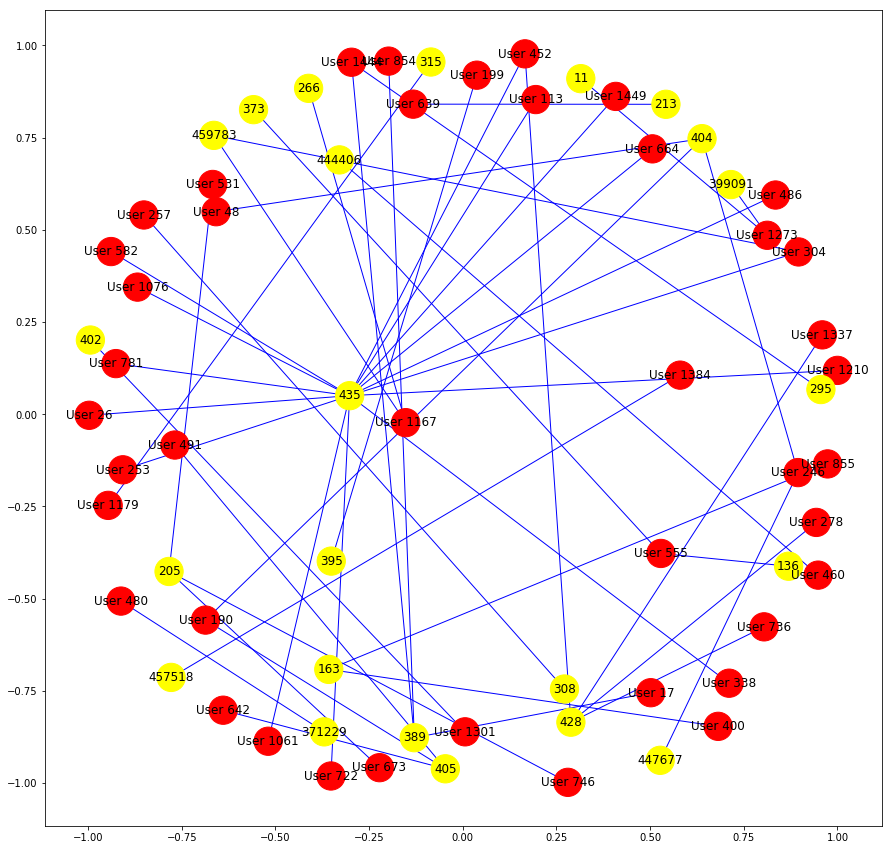

In [95]:
#create empty graph
G = nx.Graph()

#add nodes with the node attribute "bipartite"
doc = set(views_by_user[:50]['User_renamed'])
user = set(views_by_user[:50]['Page'])

G.add_nodes_from(doc, bipartite=0)
G.add_nodes_from(user, bipartite=1)

#add edges
edges = list()
for row in range(0,50):
    edge = (views_by_user.iloc[row]['User_renamed'], views_by_user.iloc[row]['Page'])
    edges.append(edge)

G.add_edges_from(edges)


#select layout
pos = nx.spring_layout(G,k=1.5)

#adjust size of th graph
plt.figure(figsize = (15,15))

#color users in red and materials in yellow
color_map = []
for node in G:
    if node in  views_by_user[:50]['User_renamed'].values:
        color_map.append('red')
    else: color_map.append('yellow')      
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), 
                       node_color = color_map, node_size = 800)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edge_color='b', arrows=True)

#display graph
plt.show()

In order to figure out which materials are related I transformed 2-mode graph to single mode graph.

In [96]:
#group by user
g = views_by_user.groupby('User_renamed')

#finds all combinations of two materials
materials_pairs = []

for user in set(views_by_user['User_renamed']):
    materials_pairs += list(combinations(g.get_group(user)['Page'].values, 2))

#find unique materials pairs
pairs_set = set(materials_pairs)

In [97]:
materials_pairs = pd.DataFrame(materials_pairs,columns=['node1','node2'])
materials_pairs.head()

,node1,node2
0,447,468863
1,447,441
2,447,466850
3,447,474536
4,468863,441


In [98]:
#group by pairs
g = materials_pairs.groupby(['node1','node2'])

In [99]:
#finds all combinations of two pairs
materials_pairs = []
material = pd.DataFrame()

for pair in pairs_set:
    count = len(g.get_group(pair))
    pair = list(pair)
    pair.append(count)
    materials_pairs.append(pair) 

In [100]:
materials = pd.DataFrame(materials_pairs, columns=['node1','node2','count'])
materials.head()

,node1,node2,count
0,468281,369847,3
1,471690,464,1
2,447664,438508,1
3,446590,450650,3
4,370516,457,1


The graph belows shows all relationships between materials.

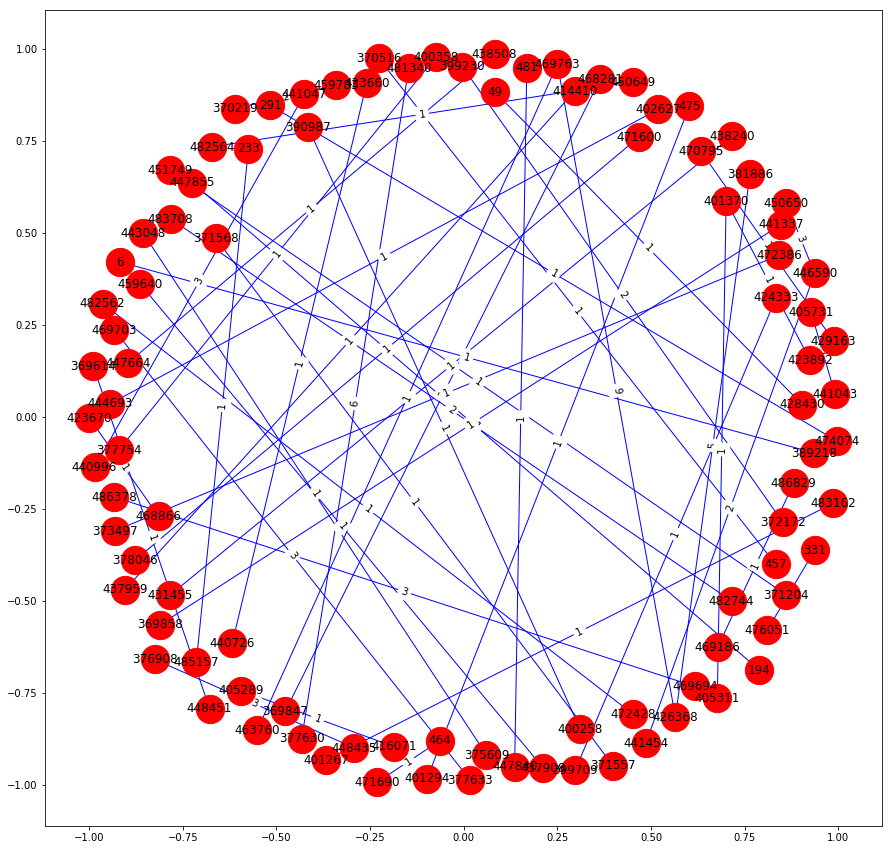

In [101]:
#create empty graph
G = nx.Graph()

#add nodes
edges = materials[['node1','node2','count']][:50].values.tolist()

#adds edges
i=0
for item in edges:
    G.add_edge(item[0],item[1],weight=item[2])

#select layout
pos = nx.spring_layout(G,k=10)

#adjust size of th graph
plt.figure(figsize = (15,15))

#pos=nx.get_node_attributes(G,'pos')      
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), 
                       node_color = 'r', node_size = 800)

labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edge_color='b', arrows=True)

nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

#display graph
plt.show()

For example, material 369549 is related to the following materials.

In [67]:
#materials[(materials['node1'] == 369549) | (materials['node2'] == 369549)]